Defining some utilitary functions and importing some modules

In [42]:
def query_TAP(tap_endpoint, adql_query, table_to_upload=None):
    """
    Query a TAP service (designated by its tap_endpoint)
    with a given ADQL query
    
    Query is performed synchronously
    
    Return an AstroPy Table object
    """
    import requests
    from astropy.table import Table
    from astropy.io.votable import parse_single_table
    import os
    import tempfile
    import warnings
    
    r = requests.post(tap_endpoint + '/sync', data={'query': adql_query, 'request': 'doQuery', 'lang': 'adql', 'format': 'votable', 'phase': 'run'})
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
    tmp_vot = tempfile.NamedTemporaryFile(delete = False)
    with open(tmp_vot.name, 'w') as h:
        for line in r.iter_lines():
            if line:
                h.write(line.decode(r.encoding)+'\n')

    table = parse_single_table(tmp_vot.name).to_table()

    # finally delete temp files
    os.unlink(tmp_vot.name)

    return table

from astroquery.xmatch import XMatch
import types
import six
from astropy.io import ascii

# monkey patching XMatch
def patched_is_table_available(self, table_id):
        if isinstance(table_id, six.string_types) and (table_id[:7] == 'vizier:'):
            table_id = table_id[7:]
        if not isinstance(table_id, six.string_types):
            return False
        
        return table_id in self.get_available_tables()
    
    
XMatch.is_table_available = types.MethodType(patched_is_table_available, XMatch)

    
from astropy import units as u

def plot_scatter_density(xdata, ydata, xlabel, ylabel, title, xlim=None, ylim=None, cmap='viridis', invert_yaxis = True, s=2, grid=False):
    import matplotlib.pyplot as plt
    import matplotlib
    %matplotlib inline
    from scipy.stats import gaussian_kde
    import numpy as np

    x = np.reshape(np.array(xdata, copy=False).astype('float'), (len(xdata)))
    y = np.reshape(np.array(ydata, copy=False).astype('float'), len(ydata))

    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    
    
    
    w = h = 8
    fig, ax = plt.subplots(figsize = (w, h))
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)
    ax.set_title(title)
    ax.scatter(x, y, c=z, s=s, edgecolor='', cmap=cmap)
    if invert_yaxis:
        ax.invert_yaxis()
    ax.grid(grid)


# Query Gaia tables in VizieR

# Query SIMBAD to retrieve stars member of a cluster and cross-match with TGAS

In [12]:
stars_in_cluster = query_TAP('http://simbad.u-strasbg.fr/simbad/sim-tap', 
                             """SELECT  ra, dec, pmra, pmdec, plx_value, plx_err FROM basic where otype_txt = '*iC'
                              and plx_value>1 and plx_value/plx_err > 5""")
print(stars_in_cluster)

        ra                 dec         ...     plx_value       plx_err  
       deg                 deg         ...        mas            mas    
------------------ ------------------- ... ------------------ ----------
161.56899012567726   -64.5145598145577 ... 6.8499999999999996 0.20999999
 48.34947130671857  48.176952442309371 ... 8.5800000000000001       0.37
 54.77802151852503  24.702873017617172 ... 8.3200000000000003 0.79000002
184.81643444292581  25.060243297651738 ... 6.4199999999999999 0.66000003
75.203695332014647  4.7331138426158796 ... 18.379999999999999  1.9400001
122.95071415191404 -12.678799803611035 ... 5.4800000000000004       1.02
52.777374097403595  50.481493286870879 ... 7.5800000000000001 0.55000001
128.83102340404923  19.590065306504904 ... 4.9299999999999997 0.55000001
141.84548228553999 -36.880150079571493 ... 8.2799999999999994 0.73000002
 188.8286403392454  36.338270781398741 ... 9.3300000000000001 0.93000001
               ...                 ... ...         

We now query the xmatch service to find counterparts in TGAS (max search radius: 1 arcsec)

In [26]:
xmatch_result = XMatch.query(cat1 = stars_in_cluster,
                             cat2 = 'vizier:I/337/tgasptyc',
                             max_distance = 1 * u.arcsec,                             
                             colRA1 = 'ra',
                             colDec1= 'dec', cache=False)

print(xmatch_result['ra', 'dec', 'plx_value', 'Plx', 'plx_err', 'e_Plx'])


      ra         RA_ICRS         dec       ...  Plx     plx_err     e_Plx
------------- ------------- -------------- ... ----- -------------- -----
48.3494713067 48.3495709535  48.1769524423 ...  9.97 0.370000004768  0.46
184.816434443 184.816561797  25.0602432977 ...  6.24 0.660000026226  0.45
 75.203695332 75.2039971193  4.73311384262 ... 19.25  1.94000005722  0.24
122.950714152 122.950702391 -12.6787998036 ...  3.21  1.01999998093  0.26
52.7773740974 52.7771573668  50.4814932869 ...  6.64 0.550000011921   0.3
128.831023404 128.830872847  19.5900653065 ...  5.24 0.550000011921  0.41
141.845482286 141.845561867 -36.8801500796 ...  8.54 0.730000019073  0.26
188.828640339 188.828142739  36.3382707814 ...   9.4 0.930000007153  0.27
189.165494777 189.165555076   25.791543079 ...  7.55  1.25999999046   0.3
182.340266498 182.340085293  29.4606042955 ...  4.97 0.730000019073  0.26
          ...           ...            ... ...   ...            ...   ...
147.795155141 147.795012773 -53.182982

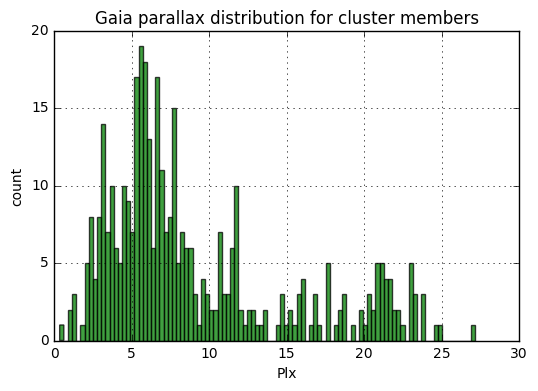

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
histvals, binvals, patches = plt.hist(xmatch_result['Plx'], bins=100, facecolor='g', alpha=0.75)

plt.xlabel('Plx')
plt.ylabel('count')
plt.title('Gaia parallax distribution for cluster members')
plt.grid(True)

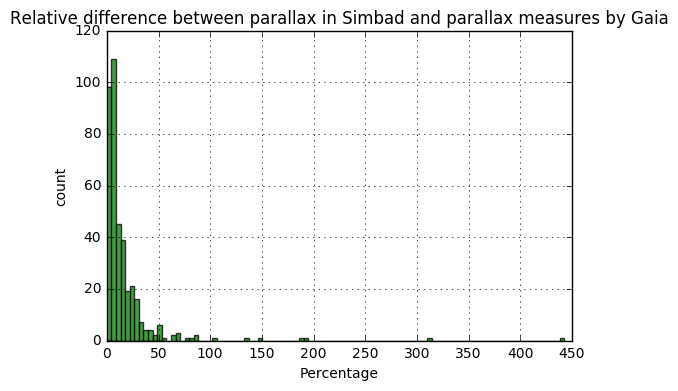

In [16]:
histvals, binvals, patches = plt.hist(100 * abs(xmatch_result['Plx'] - xmatch_result['plx_value']) / xmatch_result['Plx'], bins=100, facecolor='g', alpha=0.75)

plt.xlabel('Percentage')
plt.ylabel('count')
plt.title('Relative difference between parallax in Simbad and parallax measures by Gaia')
plt.grid(True)

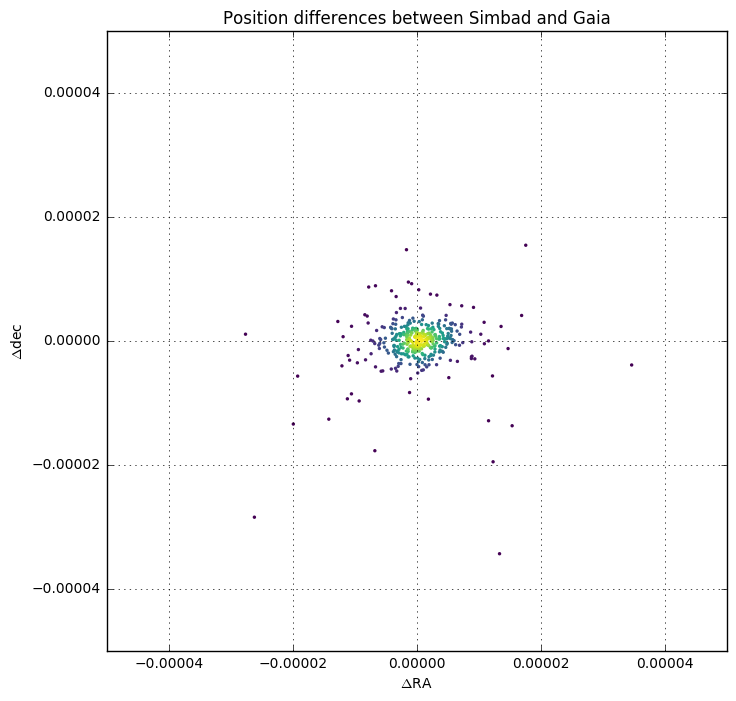

In [44]:
plot_scatter_density(xmatch_result['ra'] - xmatch_result['_RAJ2000'],
                     xmatch_result['dec']  - xmatch_result['_DEJ2000'],
                     r'$\Delta$RA', r'$\Delta$dec', 'Position differences between Simbad and Gaia', xlim=[-5e-5, 5e-5], ylim=[-5e-5, 5e-5],
                     cmap='viridis', invert_yaxis = False, s=6, grid=True)

